In [1]:
%matplotlib inline
import pyfolio as pf

In [2]:
import zipline
from zipline.api import *
from zipline.utils.events import BeforeClose
from zipline.utils.run_algo import run_algorithm
from datetime import datetime, timedelta
import pytz
import pandas as pd
import pandas_datareader.data as web

In [3]:
!zipline bundles

quandl <no ingestions>
quantopian-quandl 2017-09-27 10:45:08.190035


In [4]:
candles = 3
ticker = 'SPY'
from_date = datetime(2000,1,1, tzinfo=pytz.utc)
to_date = datetime(2014,1,1, tzinfo=pytz.utc)
capital_base = 10000

In [39]:
def initialize(context):
    context.i = 0
    context.asset = symbol(ticker)
    schedule_function(func=handle_data_eod,
                      time_rule=BeforeClose(minutes=10),# time_rules.market_close(minutes=10),
                      calendar=calendars.US_EQUITIES)

def handle_data(context, data):
    pass
    
def handle_data_eod(context, data):
    context.i += 1
    if context.i < candles:
        return

    #always close previous day
    order_target_percent(context.asset, 0)
    order_percent(context.asset, 0)

    hist = data.history(context.asset, 
                           ('open', 'high', 'low', 'close'), 
                           bar_count=candles, 
                           frequency="1d")
    current_candle = hist.iloc[-1]
    
    all_negative = ((hist['close'] - hist['open']) < 0).all()
    if all_negative:
        #current_candle = hist.iloc[-1]
        lower_bound = current_candle['low'] + (current_candle['high']-current_candle['low'])*0.75
        if current_candle['close'] > lower_bound:
            act_price = data.current(context.asset, 'price')
            print('==========\n{}\n'.format(context.datetime))
            print(hist)
            print('\ncurrent:')
            print(data.current(context.asset, ('open', 'high', 'low', 'close')))
            order_percent(context.asset, 5)
            record(history=hist)

# Data loading

### Simulate minute data

In [65]:
start = pd.Timedelta(hours=9, minutes=30)
stop = pd.Timedelta(hours=16, minutes=0)
open_minutes = 6*60+30 # 14:30 - 21:00
def new_minute_line(data, idx:int, step_size:int): # time_shift in minutes
    time_shift = idx*step_size
    indexes = data.index + pd.Timedelta(minutes=time_shift) + start
    diff = data['Close'] - data['Open']
    step = diff/open_minutes
    opens = data['Open'] + step*time_shift
    closes = opens + step*step_size
    ret = pd.DataFrame(index=indexes, data={'Open':opens.values, 'Close': closes.values})
    ret['High'] = ret[['Open','Close']].max(axis=1)*1.001
    ret['Low'] = ret[['Open','Close']].min(axis=1)*0.999
    ret['Volume'] = 0
    ret = ret[['Open', 'High', 'Low', 'Close', 'Volume']]
    return ret

### Load data from Yahoo, and fill minute data based on estimations

In [66]:
def load_data(ticker, from_date, to_date):
    from collections import OrderedDict
    data = OrderedDict()
    
    df = web.DataReader(ticker, 'yahoo', from_date, to_date)
    df.dropna(inplace=True)
    df.drop(['Adj Close'], axis=1, inplace=True)
    
    new_df = pd.DataFrame()
    step_size = 5
    for idx in range(0, open_minutes//step_size+1):
        new_line = new_minute_line(df, idx, step_size)
        new_df = new_df.append(new_line)
    new_df = new_df.append(df)
    new_df.sort_index(inplace=True)
    
    data[ticker] = new_df
    panel = pd.Panel(data)
    panel.minor_axis = ['open', 'high', 'low', 'close', 'volume']
    panel.major_axis = panel.major_axis.tz_localize(pytz.utc)

    return panel

In [67]:
data_path = './SPY.pkl'
spy_df = load_data('SPY', from_date, to_date)
spy_df.to_pickle(data_path)
spy_df = pd.read_pickle(data_path)

In [68]:
spy_df['SPY']['2010-01-04'].head(3)

,open,high,low,close,volume
Date,,,,,
2010-01-04 00:00:00+00:00,112.370003,113.389999,111.510002,113.330002,118944600.0
2010-01-04 09:30:00+00:00,112.370003,112.494693,112.257633,112.382311,0.0
2010-01-04 09:35:00+00:00,112.382311,112.507013,112.269928,112.394618,0.0


In [69]:
spy_df['SPY']['2010-01-04'].tail(1)

,open,high,low,close,volume
Date,,,,,
2010-01-04 16:00:00+00:00,113.330002,113.455652,113.216672,113.34231,0.0


In [ ]:
results = run_algorithm(from_date, 
                        to_date,
                        initialize=initialize,
                        capital_base=capital_base,
                        handle_data=handle_data,
                        data=spy_df)

/usr/local/lib/python3.4/site-packages/empyrical/stats.py:522: RuntimeWarning: invalid value encountered in double_scalars
  sortino = mu / dsr


2000-02-14 21:00:00+00:00

                             close     high      low     open
2000-02-10 00:00:00+00:00  141.562  142.562  140.875  141.625
2000-02-11 00:00:00+00:00  138.688  141.938  138.031  141.844
2000-02-14 00:00:00+00:00  139.500  139.781  138.312  139.781

current:
open     139.781204
high     139.781204
low      138.312500
close    139.500000
Name: SPY, dtype: float64
2001-02-22 21:00:00+00:00

                            close    high     low    open
2001-02-20 00:00:00+00:00  128.39  131.14  128.10  131.04
2001-02-21 00:00:00+00:00  125.62  128.84  125.50  127.90
2001-02-22 00:00:00+00:00  125.81  126.54  123.02  126.35

current:
open     126.349998
high     126.540001
low      123.019997
close    125.809998
Name: SPY, dtype: float64
2001-02-23 21:00:00+00:00

                            close    high     low    open
2001-02-21 00:00:00+00:00  125.62  128.84  125.50  127.90
2001-02-22 00:00:00+00:00  125.81  126.54  123.02  126.35
2001-02-23 00:00:00+00:00  124.96

In [61]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [62]:
positions

,Equity(0 [SPY]),cash
index,,
2000-02-15 00:00:00+00:00,50505.957652,-40508.642657
2001-02-23 00:00:00+00:00,45860.319633,-36612.399800
2001-02-26 00:00:00+00:00,47219.401110,-37000.787333
2007-12-19 00:00:00+00:00,48869.801675,-39093.075773
2007-12-21 00:00:00+00:00,50808.591715,-40728.751483
2010-05-18 00:00:00+00:00,51479.200916,-41028.071271
2012-12-28 00:00:00+00:00,50130.739642,-39978.849997


In [63]:
transactions

,amount,commission,dt,order_id,price,sid,symbol,txn_dollars
2000-02-15 21:00:00+00:00,358,None,2000-02-15 21:00:00+00:00,e51d957595b5450cbb5c5f0afa002672,141.078094,Equity(0 [SPY]),Equity(0 [SPY]),-50505.957657
2000-02-16 21:00:00+00:00,-358,None,2000-02-16 21:00:00+00:00,a6914e9e5c4e472989d089fe3d8f9b76,139.000000,Equity(0 [SPY]),Equity(0 [SPY]),49761.999992
2001-02-23 21:00:00+00:00,367,None,2001-02-23 21:00:00+00:00,5ec8ea43cbdd4798a4cf9554490dc730,124.959999,Equity(0 [SPY]),Equity(0 [SPY]),-45860.319635
2001-02-26 21:00:00+00:00,-367,None,2001-02-26 21:00:00+00:00,2f7dbc954a4a4e3a8c9ef511bf2179a7,127.620003,Equity(0 [SPY]),Equity(0 [SPY]),46836.541096
2001-02-26 21:00:00+00:00,370,None,2001-02-26 21:00:00+00:00,ab564fcbd4144734b07367f1e4506de4,127.620003,Equity(0 [SPY]),Equity(0 [SPY]),-47219.401129
2001-02-27 21:00:00+00:00,-370,None,2001-02-27 21:00:00+00:00,603361653f6643f29a5322aca5671433,126.440002,Equity(0 [SPY]),Equity(0 [SPY]),46782.800735
2007-12-19 21:00:00+00:00,335,None,2007-12-19 21:00:00+00:00,01a6ee64c72e419f99c4397bf56b96e1,145.880005,Equity(0 [SPY]),Equity(0 [SPY]),-48869.801675
2007-12-20 21:00:00+00:00,-335,None,2007-12-20 21:00:00+00:00,97e5210b2b254913830695d1513a1919,146.800003,Equity(0 [SPY]),Equity(0 [SPY]),49178.001005
2007-12-21 21:00:00+00:00,343,None,2007-12-21 21:00:00+00:00,588e85dba2274dafb172737288a28cc3,148.130005,Equity(0 [SPY]),Equity(0 [SPY]),-50808.591715
2007-12-24 18:00:00+00:00,-343,None,2007-12-24 18:00:00+00:00,8e438cc2c6144548b93b5b30cddd7c3d,149.229996,Equity(0 [SPY]),Equity(0 [SPY]),51185.888628


Entire data start date: 2000-01-03
Entire data end date: 2013-12-31
Backtest months: 167


/usr/local/lib/python3.4/site-packages/empyrical/stats.py:954: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


,Backtest
Annual return,0.7%
Cumulative returns,10.0%
Annual volatility,4.5%
Sharpe ratio,0.17
Calmar ratio,0.09
Stability,0.67
Max drawdown,-7.5%
Omega ratio,1.74
Sortino ratio,0.32
Skew,15.97


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.52,2000-02-14,2001-02-23,2001-02-26,271
1,4.32,2001-02-26,2007-12-19,2007-12-24,1781
2,2.90,2010-05-17,2012-12-28,2012-12-31,686
3,0.00,2000-01-03,2000-01-03,2000-01-03,1
4,0.00,2000-01-03,2000-01-03,2000-01-03,1


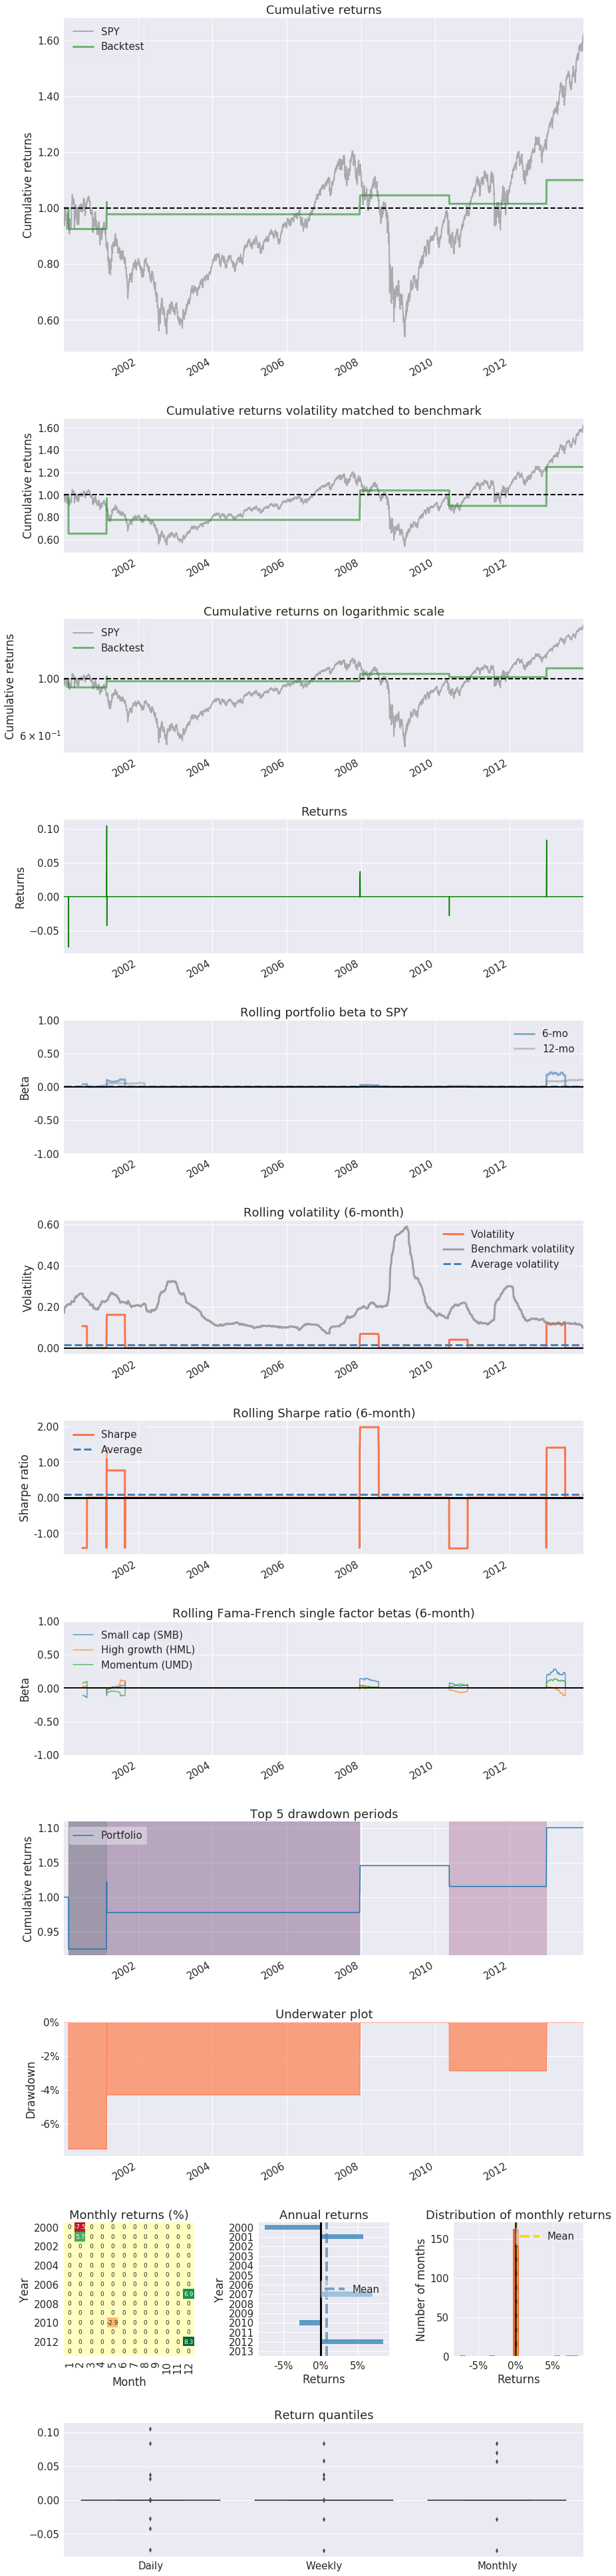

Stress Events,mean,min,max
Dotcom,0.00%,0.00%,0.00%
Lehmann,0.00%,0.00%,0.00%
9/11,0.00%,0.00%,0.00%
US downgrade/European Debt Crisis,0.00%,0.00%,0.00%
Fukushima,0.00%,0.00%,0.00%
US Housing,0.00%,0.00%,0.00%
EZB IR Event,0.00%,0.00%,0.00%
Aug07,0.00%,0.00%,0.00%
Mar08,0.00%,0.00%,0.00%
Sept08,0.00%,0.00%,0.00%


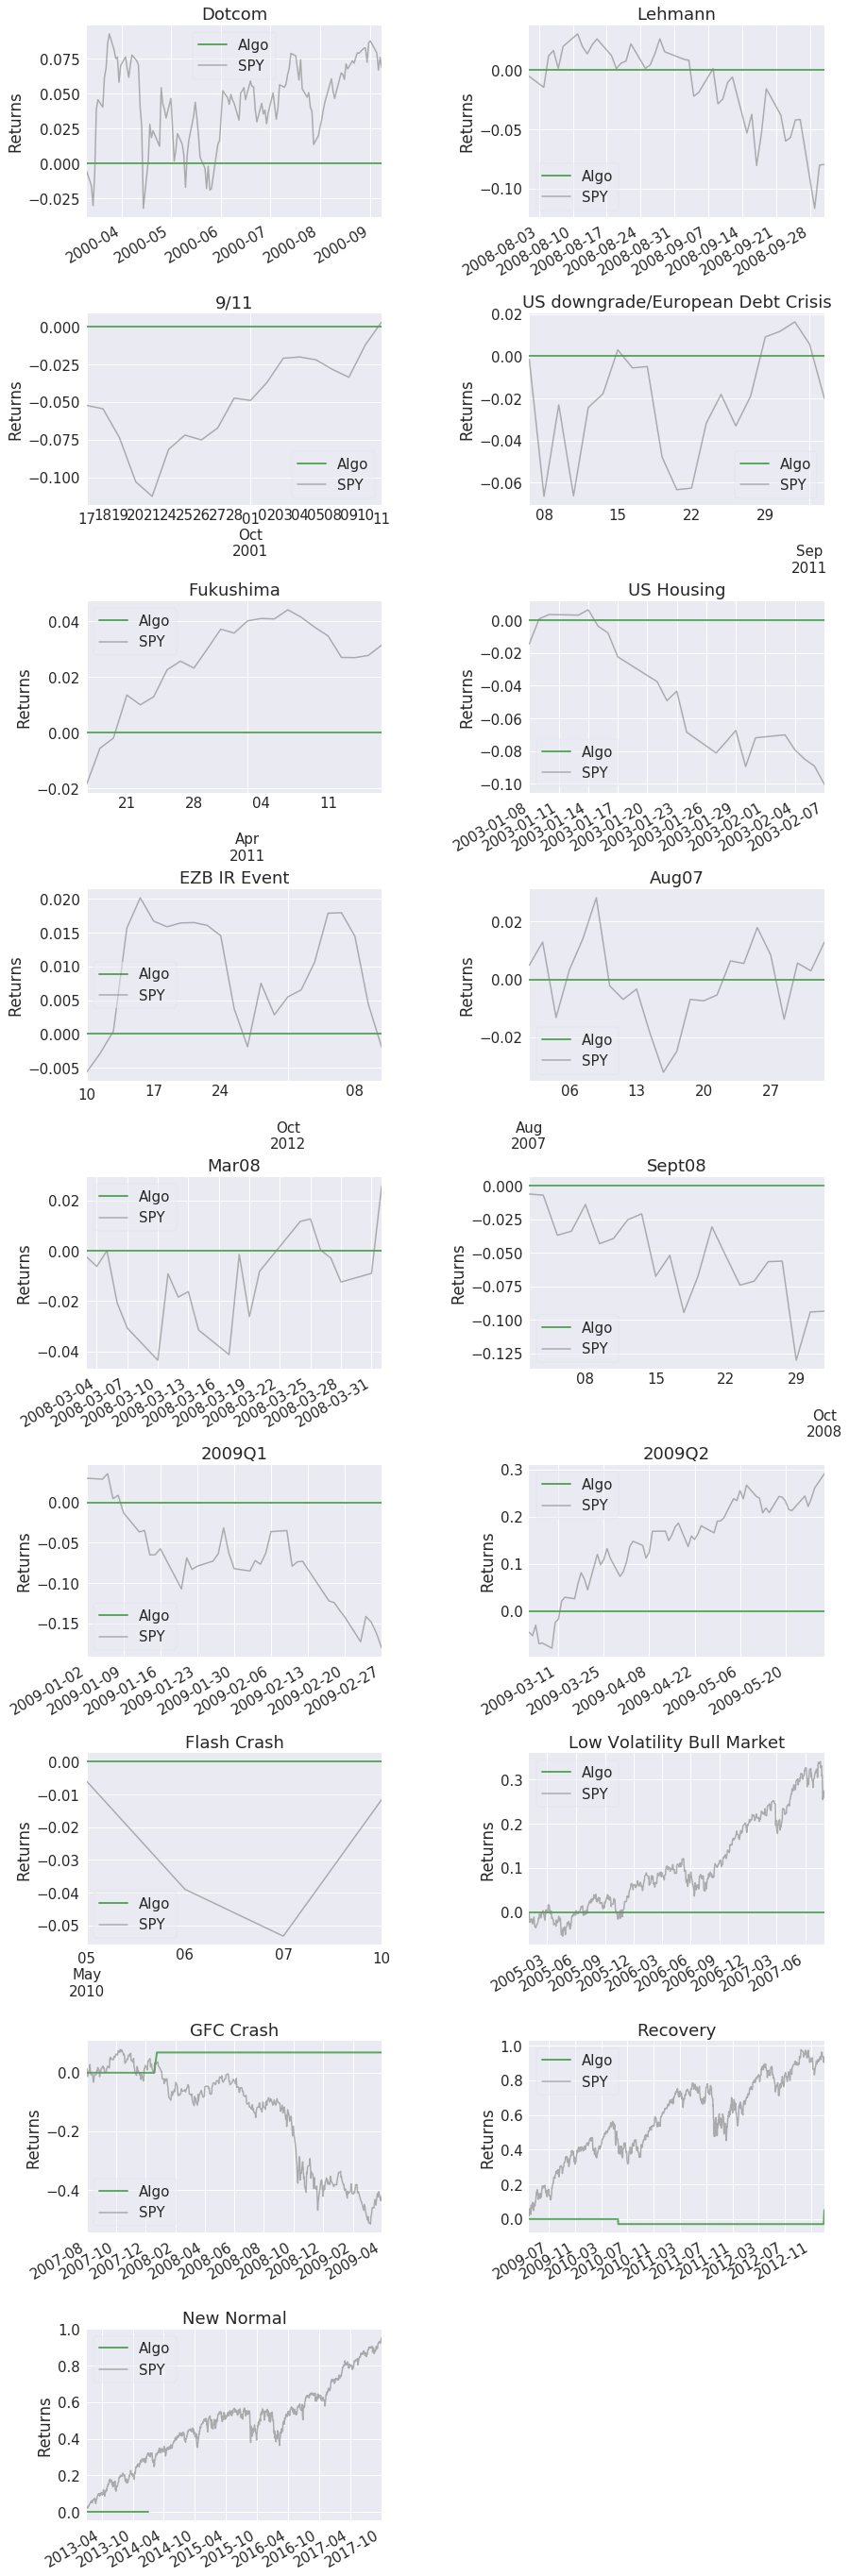

Top 10 long positions of all time,max
SPY,505.20%


Top 10 short positions of all time,max


Top 10 positions of all time,max
SPY,505.20%


All positions ever held,max
SPY,505.20%


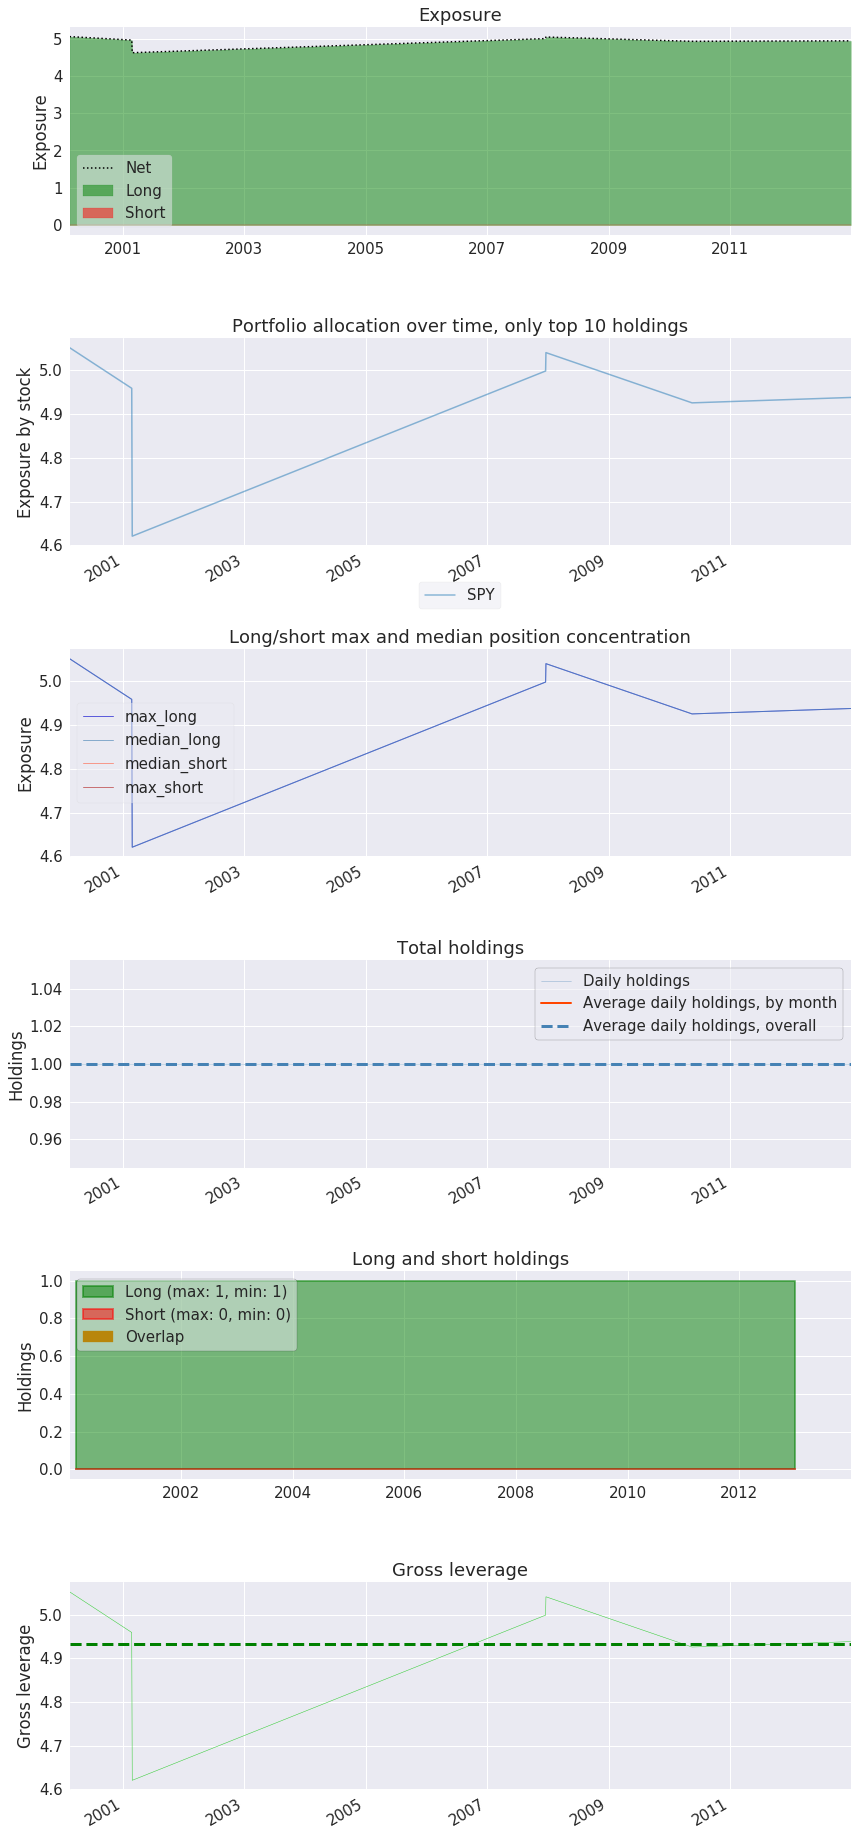

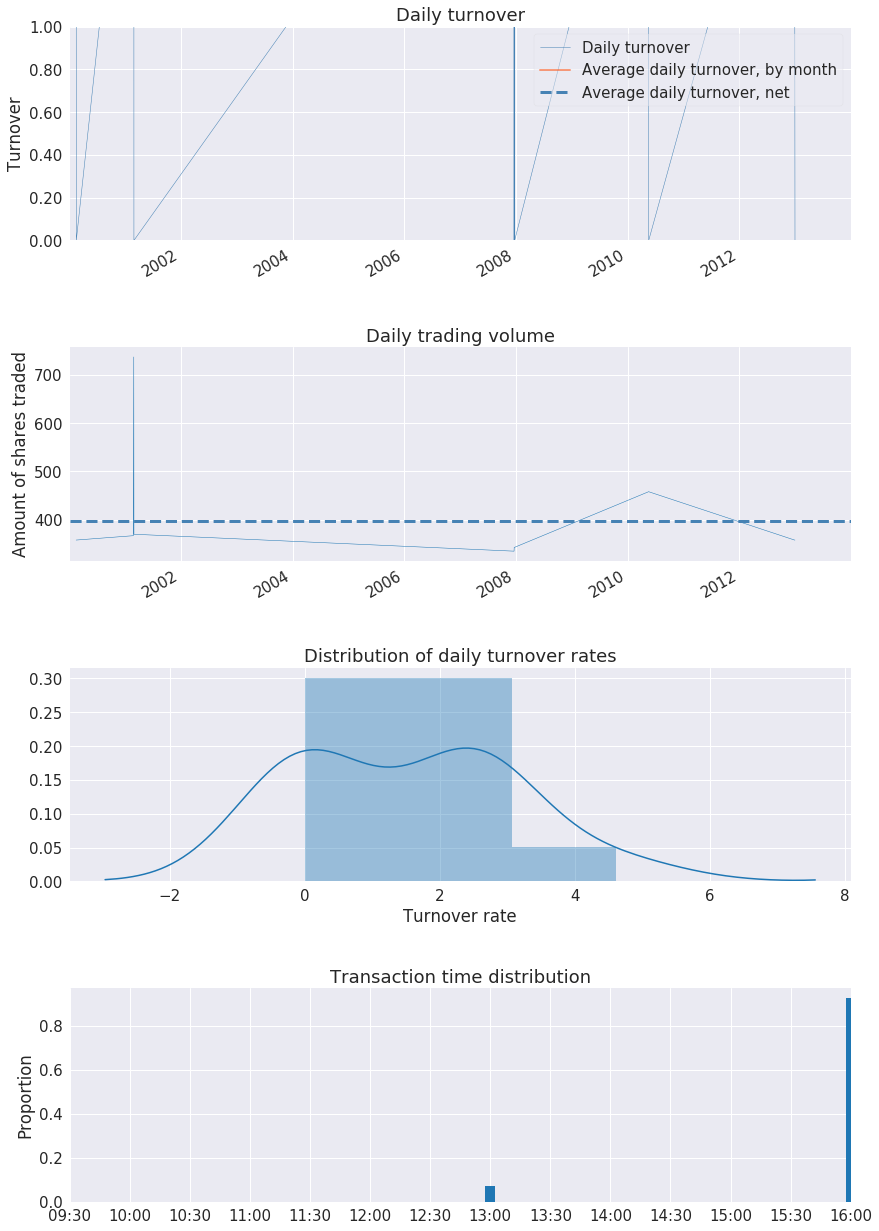

/usr/local/lib/python3.4/site-packages/pyfolio/round_trips.py:309: RuntimeWarning: divide by zero encountered in double_scalars
  ending_price = ending_val / ending_amount


Summary stats,All trades,Long trades
Total number of round_trips,7.00,7.00
Percent profitable,0.57,0.57
Winning round_trips,4.00,4.00
Losing round_trips,3.00,3.00
Even round_trips,0.00,0.00


PnL stats,All trades,Long trades
Total profit,$1040.08,$1040.08
Gross profit,$2513.76,$2513.76
Gross loss,$-1473.68,$-1473.68
Profit factor,$1.71,$1.71
Avg. trade net profit,$148.58,$148.58
Avg. winning trade,$628.44,$628.44
Avg. losing trade,$-491.23,$-491.23
Ratio Avg. Win:Avg. Loss,$1.28,$1.28
Largest winning trade,$976.22,$976.22
Largest losing trade,$-743.96,$-743.96


Duration stats,All trades,Long trades
Avg duration,1 days 20:08:34.285714,1 days 20:08:34.285714
Median duration,1 days 00:00:00,1 days 00:00:00
Longest duration,3 days 00:00:00,3 days 00:00:00
Shortest duration,1 days 00:00:00,1 days 00:00:00


Return stats,All trades,Long trades
Avg returns all round_trips,10.56%,10.56%
Avg returns winning,10.56%,10.56%
Avg returns losing,nan%,nan%
Median returns all round_trips,10.56%,10.56%
Median returns winning,10.56%,10.56%
Median returns losing,nan%,nan%
Largest winning trade,10.56%,10.56%
Largest losing trade,10.56%,10.56%


Symbol stats,SPY
Avg returns all round_trips,10.56%
Avg returns winning,10.56%
Avg returns losing,nan%
Median returns all round_trips,10.56%
Median returns winning,10.56%
Median returns losing,nan%
Largest winning trade,10.56%
Largest losing trade,10.56%


Profitability (PnL / PnL total) per name,
SPY,100.00%


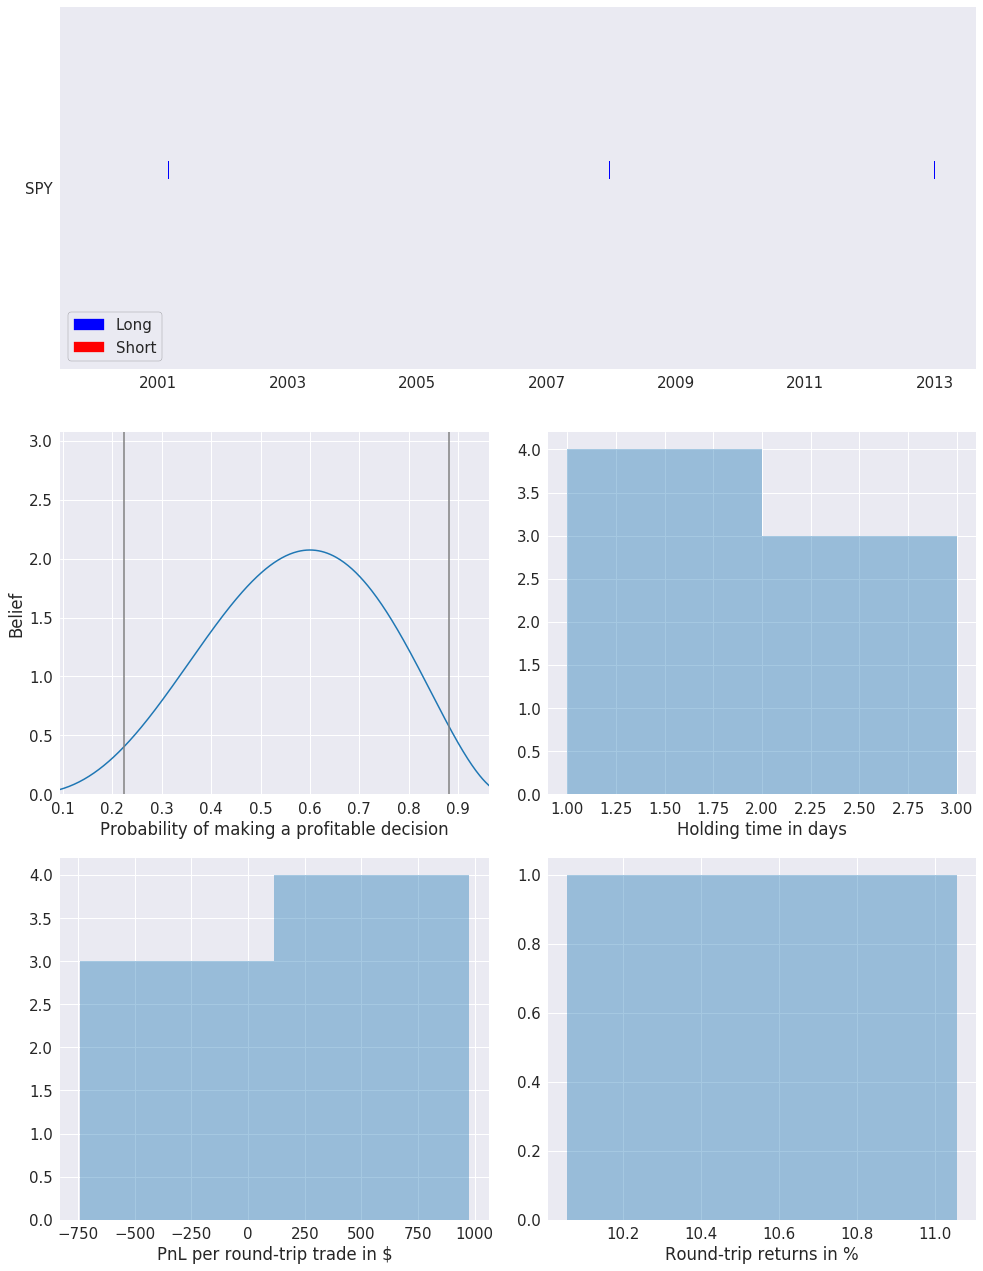

In [64]:
pf.create_full_tear_sheet(returns, positions, transactions, round_trips=True)